# WASP AI&ML Course 2024 - Module 1 Assignment

**Project** : *MAS Assignment 1*

**Author** : *Sebastiano Fregnan*

**Institution** : *Lund University*

**Date** : *27/05/2024*

**Repository** : [github.com/ilVecc/wasp-aiml2024](https://github.com/ilVecc/wasp-aiml2024)

## Description

In the context of the first module of the WASP AI & ML Course, a in-person experiment was performed. In that experiment, people were placed in a large room, asked to wear a labeled colored t-shirt, and instructed to silently and independently position themselves complying to some simple rules (eg. in the middle of your neighbors wearing a yellow t-shirt, next to a t-shirt with label "A"). The overall behaviour appeared to be forcibly convergent, meaning that everyone was willing to break some rules for the sake of getting the task done. This means that decision was non-local, with people waiting each other to avoid collisions, taking into account more than the allowed information (eg. looking to non-immediate neighbors), and ultimately talking out the best strategy. 

## Task


With this assignment we want to eliminate natural human decisions from the experiment and focus on the underlying swarm behaviour. In particular, we want to study two positioning scenarios:
1. always position yourself between A and B;
2. always position yourself so that B is between A and yourself;

under the assumptions:
- the room is free of obstacles;
- each agent uses local decision-making strategies.

Finally, convergence and sensitivity to different parameter settings (eg. perception radius, heterogeneity of speed, limited workspace) are to be analyzed.

## Model


In this simulation, we use mass-less particles in place of humans, and we provide a framework that allows to customize each one of them with different characteristic functions. In this way, the particles follow no specific model, but rather are very general and flexible objects that can be modeled as desired. In particular, one can customize any of the following characteristic:
- _initial position vector_;
- _initial velocity vector_;
- _neighbor selection function_, which specifies how to select neighbors;
- _position calculation policy_, which specifies how to calculate the next position;
- _velocity calculation policy_, which specifies how to calculate the next velocity;
- _particle state space_, which specifies where the particle can be.

In this Python notebook, a number of functions have been already implemented for the sake of running multiple experiments to better illustrate the swarm behaviour. Feel free to create new characteristic functions and try out alternative conditions. 

## Simulator


To reproduce swarm behaviour, we propose a simple Python simulator with very few requirements. In particular, we use NumPy to speed up linear algebra and MatPlotLib to plot the final results. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

def plot(sim_res, repeats=1, title="", ax=None):
    if ax is None:
        ax = plt.axes()
    cmap = cm["hsv"]
    n = sim_res["n"]
    n_reps = n / repeats
    for i in range(n):
        c = cmap((i%n_reps)/n_reps)
        # plot trajectory
        pos = np.array(sim_res["history_pos"][i])
        ax.plot(pos[:, 0], pos[:, 1], color=c)
        # plot final point
        pos = np.array(sim_res["history_pos"][i][-1])
        ax.scatter(pos[0], pos[1], color=c, s=5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)

    # plot termination label
    term = sim_res["termination_code"]
    if term == 0:
        label = "OK"
    elif term == 1:
        label = "IT"
    elif term == 2:
        label = "RNG"
    else:
        label = "??"
    ax.annotate(label,
                xy=(0.0, 1.0), xycoords='axes fraction',
                xytext=(0, 0), textcoords='offset points',
                ha="center", va="center",
                size=10, 
                bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"))

def normalize(a, return_norm=False):
    norm = np.linalg.norm(a, axis=-1, keepdims=True)
    b = a.copy() / (norm + (norm == 0))
    if return_norm:
        return b, norm
    return b

In addition, we include video renderings of the simulations using Manim, a popular mathematical visualization tool. This is effortless to install and provides much better final results compared to the static MatPlotLib plots.

In [2]:
import manim
manim.config.verbosity = "WARNING"
manim.config.background_color = manim.WHITE
manim.config.disable_caching = True
manim.config.quality = "low_quality"  # for fast rendering
from matplotlib import colormaps as cm

class HumanSwarm(manim.Scene):
    def construct(self):

        if not hasattr(self, "pr"):
            self.pr = 0
        if not hasattr(self, "pa"):
            self.pa = 2*np.pi
        
        ax = manim.Axes(
            x_range=[-4, 4], 
            y_range=[-4, 4],
            x_length = 7, 
            y_length = 7, 
            tips=False
        )
        self.add(ax)

        t = manim.ValueTracker(0)
        
        hp = lambda i : (1 - (t.get_value() - int(t.get_value()))) * self.sim["history_pos"][i][int(t.get_value())] \
                           + (t.get_value() - int(t.get_value()))  * self.sim["history_pos"][i][min(int(t.get_value())+1, len(self.sim["history_pos"][i]))]
        hv = lambda i : self.sim["history_vel"][i][int(t.get_value())]
        hn = lambda i : self.sim["history_neighs"][i][int(t.get_value())]

        cmap = cm["hsv"]
        dots = {}
        for i in range(self.sim["n"]):
            color = manim.utils.color.rgba_to_color(cmap(i/self.sim["n"]))
            # moving particle
            dot = manim.always_redraw(
                lambda i=i, color=color : 
                    manim.Dot(point=ax.c2p(*hp(i)), color=color, z_index=1000)
            )
            self.add(dot)
            dots[i] = dot
            # and its velocity
            vel = manim.always_redraw(
                lambda i=i : 
                    manim.Arrow(start=ax.c2p(*hp(i)), end=ax.c2p(*(hp(i)+hv(i))))
                        .set_color(dots[i].color)
                        .set_opacity(0.65)
            )
            self.add(vel)
            # and its perception radius
            rad = manim.always_redraw(
                lambda i=i : 
                    manim.AnnularSector(
                        inner_radius=0, 
                        outer_radius=self.pr if not np.isinf(self.pr) else 0, 
                        angle=self.pa * (np.linalg.norm(hv(i)) > 0), 
                        start_angle=-self.pa/2)
                        .set_color(dots[i].color)
                        .set_opacity(0.10)
                        .rotate_about_origin(np.arctan2(*hv(i)[::-1]))
                        .move_arc_center_to(dots[i].get_center())
            )
            self.add(rad)
            # and its trail
            path = manim.TracedPath(dot.get_center, dissipating_time=2.0, stroke_opacity=[0, 1], stroke_color=dot.color)
            self.add(path)
            
        for i in range(self.sim["n"]):
            # and its neighbors
            def draw_neighs_lines(idx):
                return manim.VGroup(
                    *[manim.Line(start=dots[idx].get_center(), end=dots[n].get_center())
                           .set_color(dots[idx].color)
                           .set_opacity(0.45)
                     for n in hn(idx)]
                )
            lines = manim.always_redraw(lambda idx=i : draw_neighs_lines(idx))
            self.add(lines)
        
        frames = self.sim["iterations"]
        self.play(t.animate.set_value(frames-1), run_time=10, rate_func=manim.linear)
        self.wait(2)

Now we load the `Particle` class, which as clearly stated above does not contain much, but allows for great customization. The `run_simulation` function will be in charge of moving the particles at each time step, until convergence or other termination criteria are reached. In particular, the simulation will stop if all the particles are near to the desired position and their velocity is near zero. Otherwise, a the simulation is stopped when the iterations reach a certain threshold or the particles go beyond a certain distance from the initial baricenter. 

In [3]:
class Particle(object):
    
    def __init__(self, init_pos, get_neighbors, get_position, get_velocity, init_vel=np.zeros((2,)), state_space=None, **kwargs):
        super(Particle, self).__init__()
        self.pos = init_pos
        self.vel = init_vel
        self.calculate_neighbors = get_neighbors
        self.calculate_position = get_position
        self.calculate_velocity = get_velocity
        self.limits = state_space if state_space is not None else (lambda pos : pos)
        # check state space
        self.pos = self.limits(self.pos)
        # history
        self.new_pos = None
        self.new_vel = None
        # any other property useful for the specific case
        self.props = kwargs
    
    def compute(self, others):
        # move towards current velocity
        self.new_pos = self.limits(self.pos + self.vel)
        # filter out the neighbors among all the other particles
        neighs = self.calculate_neighbors(self, others)
        # find the desired position using the policy...
        pos_des = self.calculate_position(self, neighs)
        # ... and create the new velocity vector
        self.new_vel = self.calculate_velocity(self, pos_des)
        # return everything new
        return self.new_pos, self.new_vel, neighs
    
    def update(self):
        self.pos = self.new_pos
        self.vel = self.new_vel

def run_simulation(particles, max_iter=3000, term_eps_pos=0.0001, term_eps_vel=0.001, term_radius=10, verbose=False):
    # prepare simulation results
    sim_res = {
        "n" : len(particles), 
        "history_pos" : [ [x.pos.copy()] for x in particles ],
        "history_vel" : [ [x.vel.copy()] for x in particles ],
        "history_neighs" : [ [[i, i]] for i in range(len(particles)) ],
        "termination_code" : 0,
        "termination_msg" : "simulation ended smoothly",
        "iterations" : 0
    }
    # use list neighbors if a list of integers is provided
    for i in range(len(particles)):
        if isinstance(particles[i].calculate_neighbors, list):
            neighbors = [particles[j] for j in particles[i].calculate_neighbors]
            particles[i].calculate_neighbors = lambda x, y, n=neighbors : neighs_policy_list(x, y, n)
    # simulate the system
    lookup_particles_index = {p: i for i, p in zip(range(sim_res["n"]), particles)}
    avg_pos = np.mean([p.pos for p in particles], axis=0)
    for it in range(max_iter):
        term_ok = True
        term_bad = False
        # compute next positions and velocities
        for i in range(sim_res["n"]):
            others = [particles[j] for j in range(sim_res["n"]) if j != i]
            new_pos, new_vel, neighs = particles[i].compute(others)
            # save history of each particle
            sim_res["history_pos"][i].append(new_pos)
            sim_res["history_vel"][i].append(new_vel)
            sim_res["history_neighs"][i].append([lookup_particles_index[n] for n in neighs])
        # apply next positions and velocities, and check termination
        for i in range(sim_res["n"]):
            pos_old = particles[i].pos
            particles[i].update()
            pos_new = particles[i].pos
            vel_new = particles[i].vel
            # update termination state
            term_ok &= np.linalg.norm(pos_new - pos_old) < term_eps_pos and np.linalg.norm(vel_new) < term_eps_vel 
            term_bad |= np.linalg.norm(pos_new - avg_pos) > term_radius
        if term_ok:
            break
        if term_bad:
            sim_res["termination_code"] = 2
            sim_res["termination_msg"] = "particles are too far away from center"
            break
    else:
        sim_res["termination_code"] = 1
        sim_res["termination_msg"] = "reached iterations limit"
    # save final iterations
    sim_res["iterations"] = it+1
    # print termination message if requested
    if verbose:
        print(sim["termination_msg"])
    return sim_res

Finally, in the following blocks there are some examples of characteristic functions for the particles. In particular, we provide four neighbor selection policies:
- fixed : each particle sees as neighbors a constant random choice;
- list : each particles has a specific list of neighbors;
- nearest global : each particle sees all the environment and chooses the nearest `k` neighbors;
- nearest radius : each particle sees up to a certain distance from itself and chooses the nearest `k` neighbors;
- nearest cone : each particle sees a cone in the direction it is travelling and chooses the nearest `k` neighbors;

In [4]:
def neighs_policy_fixed(this, others, k=2):
    """ Use randomly selected neighbors. """
    gen = np.random.default_rng(seed=hash(this))
    neighs = gen.choice(others, k, replace=False)
    return neighs.tolist()

def neighs_policy_list(this, others, neighs):
    """ Use provided neighbors. """
    return neighs

def neighs_policy_nearest_global(this, others, k=2):
    """ Filter out the k nearest neighbors. """
    return neighs_policy_nearest_radius(this, others, np.inf, k)

def neighs_policy_nearest_radius(this, others, radius, k=2):
    """ Filter out the k nearest neighbors within the provided radius. """
    dist = [np.linalg.norm(this.pos - x.pos) for x in others]
    best_k_idxs = np.argsort(dist)[:k]
    # filter the indices of the neighbors in the radius, duplicating the node 
    # in the empty buffer spots if needed
    # Note: the duplicated node is placed as the nearest of its neighbors
    neighs = [others[i] for i in best_k_idxs if dist[i] < radius]
    neighs = [this for _ in range(k - len(neighs))] + neighs
    return neighs

def neighs_policy_nearest_cone(this, others, radius, angle, k=2):
    """ Filter out the k nearest neighbors within the provided radius and angle in the velocity direction. """
    pos_rel = np.array([x.pos - this.pos for x in others])
    new_dir = normalize(pos_rel)
    old_dir = normalize(this.vel)
    angle_err = np.arccos(np.clip(np.sum(old_dir * new_dir, axis=-1), -1, +1))
    fov = angle_err <= angle/2
    others_in_fov = [others[i] for i in range(len(others)) if fov[i]]
    
    return neighs_policy_nearest_radius(this, others_in_fov, radius, k)

... the two required positioning policies:
- policy 1 : position yourself between two particles (with this implementation, we position ourselves in the middle between A and B by default);
- policy 2 : position yourself in a line after the other two particles (with this implementation, we position B in the middle between A and ourselves by default);

In [5]:
def position_policy_1(this, neighs, alpha=0.5):
    """ Policy 1: be the man in the middle. """
    pos_des = alpha * neighs[0].pos + (1 - alpha) * neighs[1].pos
    return pos_des

def position_policy_2(this, neighs, scale=1.0, flipped=False):
    """ Policy 2: be the man to the right. """
    # flip the way neighbors are considered
    n0, n1 = neighs[0].pos, neighs[1].pos
    if flipped:
        n0, n1 = n1, n0
    vec = n1 - n0
    dir, norm = normalize(vec, return_norm=True)
    # if scale is integer, then use it as the length between the particles
    # if scale is a float, then use it as percentage for the space between the particles
    vec = scale * (norm if isinstance(scale, float) else 1) * dir
    pos_des = n1 + vec
    return pos_des

... two velocity policies:
- simple : aim towards the desired position with a little amplitude discount;
- constrained : aim towards the desired position with constraints on amplitude increase and steering angle, and a little discount;

In [6]:
def velocity_policy_simple(this, pos_des, discount=0.2):
    pos_err = pos_des - this.pos
    # add a little discount
    return discount * pos_err

def velocity_policy_constr(this, pos_des, max_vel=1.5, max_vel_diff=0.4, max_angle_diff=np.radians(1), discount=0.2):
    pos_err = pos_des - this.pos
    new_dir, new_norm = normalize(pos_err, return_norm=True)
    old_dir, old_norm = normalize(this.vel, return_norm=True)
    # calculate new direction with maximum angle constraint
    if old_norm != 0:
        angle = np.arccos(np.clip(old_dir @ new_dir, -1, +1))  # returns [0, pi]
        axis = np.cross(old_dir, new_dir)
        new_angle = np.sign(axis) * min(angle, max_angle_diff)
        c, s = np.cos(new_angle), np.sin(new_angle)
        new_dir = np.array([[c, -s], [s, c]]) @ old_dir
    # calculate new amplitude with maximum velocity constraint
    sign = np.sign(np.sign(new_norm - old_norm) + .5)  # when sign is 0, force it to 1
    incr = min(max_vel_diff, abs(new_norm - old_norm))
    new_norm = sign * incr + old_norm
    new_norm = min(max_vel, new_norm)
    # glue all together and discount it a little
    vel_new = new_norm * new_dir
    return discount * vel_new

... and two state spaces:
- box : a simple rectangular box around a center (default origin);
- circle : a simple circle around a center (default origin).

In [7]:
def state_space_box(pos, size, center=np.zeros(2)):
    min_y, max_y, min_x, max_x = size
    return center + np.clip(pos - center, [min_x, min_y], [max_x, max_y])

def state_space_circle(pos, radius, center=np.zeros(2)):
    pos_rel = pos - center
    axis, norm = normalize(pos_rel, return_norm=True)
    norm = min(radius, norm)
    pos_rel = norm * axis
    return center + pos_rel

With all these ingredients in place, we are finally able to run some examples and study the behaviour of the system given the various configurations. To reduce the amount of boilerplate in the following examples, we also define a couple of handy functions:

In [8]:
pos = lambda p : np.random.uniform(-p, +p, (2,))
vel = lambda v : np.random.uniform(-v, +v, (2,))

## Experiments

### Policy 1

As initial exploration, we start with a simple 3-particles scenario, using Policy 1. We choose the simple velocity policy and list neighbors (we can provide a list of indices instead of a neighbor policy), while the state is unconstrained for every particle. In the plot, each particle has a unique color (if at most 20 partciles are visualized) and each final position is visualized as a dot. In the top-left corner a label reports how the simulation ended: OK if simulation ended successfully, IT if the maximum iterations threshold was reached, RNG if maximum allowed range was exceeded, and ?? if none of the previous apply (this should never happen).

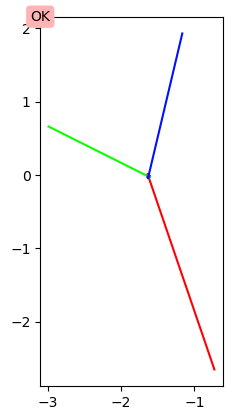

In [9]:
np.random.seed(223695)

pol_pos = position_policy_1
pol_vel = velocity_policy_simple

particles = [
    Particle(init_pos=pos(3), get_neighbors=[1, 2], get_position=pol_pos, get_velocity=pol_vel),
    Particle(init_pos=pos(3), get_neighbors=[2, 0], get_position=pol_pos, get_velocity=pol_vel),
    Particle(init_pos=pos(3), get_neighbors=[0, 1], get_position=pol_pos, get_velocity=pol_vel)]
res = run_simulation(particles)
plot(res)

To see the evolution of the particles, we resort to the Manim library. To do so, simply run the code below (for all the following examples, the renderings are already available, so there is no need to run again the blocks). In the animation, each particle shows a link to its neighbors and its current velocity vector. Colors will be different from the static plot.

In [10]:
%%manim Swarm
class Swarm(HumanSwarm):
    def setup(self):
        self.sim = res

Manim Community v0.18.1

The behaviour of the system is convergent. This is due to the fact that the system can be described as the following linear dynamical system
$$\dot{\xi}_i = -\xi_i + \frac{1}{2}\xi_j + \frac{1}{2}\xi_k$$
where $\xi_i = [x_i, y_i]$ is the position of particle $i$, with $j$ and $k$ being its neighbors. In this scenario, wlof we can describe the system with
$$
\begin{matrix}
\dot{\xi}_1 = -\xi_1 + \frac{1}{2}\xi_2 + \frac{1}{2}\xi_3 \\
\dot{\xi}_2 = \frac{1}{2}\xi_1 - \xi_2 + \frac{1}{2}\xi_3 \\
\dot{\xi}_3 = \frac{1}{2}\xi_1 + \frac{1}{2}\xi_2 -\xi_3
\end{matrix}
\implies 
\begin{bmatrix} \dot{\xi}_1 \\ \dot{\xi}_2 \\ \dot{\xi}_3 \end{bmatrix} 
= \begin{bmatrix} -I_2 & \frac{1}{2}I_2 & \frac{1}{2}I_2 \\ \frac{1}{2}I_2 & -I_2 & \frac{1}{2}I_2 \\ \frac{1}{2}I_2 & \frac{1}{2}I_2 & -I_2 \end{bmatrix} 
\begin{bmatrix} \xi_1 \\ \xi_2 \\ \xi_3 \end{bmatrix}
$$
where $I_2$ is the two-dimensional identity matrix. By studying the eigenvalues of the system

In [11]:
A = np.array([[-1, 0.5, 0.5], 
              [0.5, -1, 0.5], 
              [0.5, 0.5, -1]])
with np.printoptions(suppress=True):
    print(np.sort(np.linalg.eigvals(A)))

[-1.5 -1.5  0. ]


we can see that (for each axis) there are two asymptotically stable eigenvalues and one zero, which adds an undamped oscillatory behaviour to the system. Overall, the system is stable, and will either converge to a single equilibrium point or be forever stuck in a limit cycle (we will see this later with a specific example).

Clearly, as we change the initial velocity of a particle, its behaviour changes but, as described above, convergence remains nonetheless. We can set the initial velocity using the `init_vel` parameter.

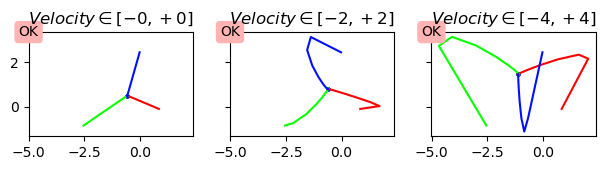

In [12]:
np.random.seed(132453)

n = 3
poss = [pos(3) for i in range(n)]
pol_pos = position_policy_1
pol_vel = velocity_policy_simple
pol_neigh = neighs_policy_fixed

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.tight_layout()
p1 = [Particle(init_pos=poss[i], init_vel=vel(0), get_neighbors=pol_neigh, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
p2 = [Particle(init_pos=poss[i], init_vel=vel(2), get_neighbors=pol_neigh, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
p3 = [Particle(init_pos=poss[i], init_vel=vel(4), get_neighbors=pol_neigh, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
plot(run_simulation(p1), title=r"$Velocity \in [-0,+0]$", ax=ax[0])
plot(run_simulation(p2), title=r"$Velocity \in [-2,+2]$", ax=ax[1])
plot(run_simulation(p3), title=r"$Velocity \in [-4,+4]$", ax=ax[2])

From now on, we will skip the systematic analysis of the behaviour, due both to impracticality and complexity in modeling the system. 

In the following examples, we have restricted the way the velocity can change, using the `velocity_policy_constr` function. Here we allow for a maximum of 0.25 difference in velocity amplitute and 15deg in velocity angle, while constraining the velocity to be below 10. These constraints help adding some realistic behaviour to the particles, which now follow a more gentle and natural-looking trajectory.

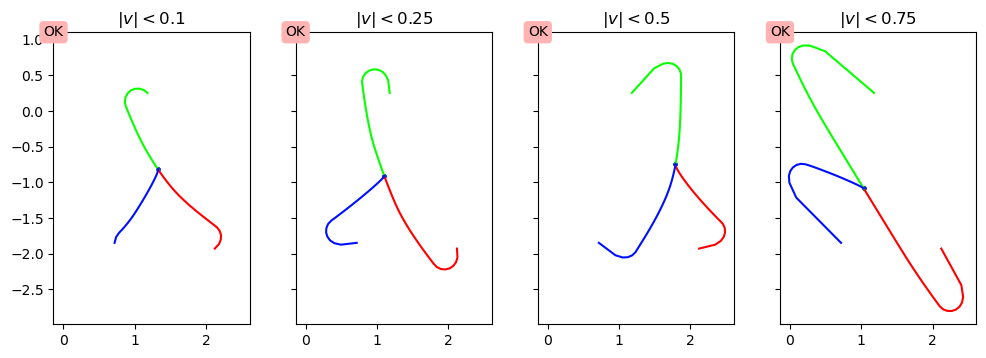

In [13]:
np.random.seed(324462)

n = 3
poss = [pos(3) for i in range(n)]
pol_pos = position_policy_1
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.25, max_angle_diff=np.radians(20))
pol_neighs = neighs_policy_fixed

fig, ax = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
fig.tight_layout()
p1 = [Particle(init_pos=poss[i], init_vel=vel(0.10), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
p2 = [Particle(init_pos=poss[i], init_vel=vel(0.25), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
p3 = [Particle(init_pos=poss[i], init_vel=vel(0.50), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
p4 = [Particle(init_pos=poss[i], init_vel=vel(0.75), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(n)]
plot(run_simulation(p1), title=r"$|v| < 0.1$", ax=ax[0])
plot(run_simulation(p2), title=r"$|v| < 0.25$", ax=ax[1])
plot(run_simulation(p3), title=r"$|v| < 0.5$", ax=ax[2])
plot(run_simulation(p4), title=r"$|v| < 0.75$", ax=ax[3])

Regardless of the initial velocity and position, the system appears to be always convergent. This is rather obvious, since the particles want to position themselves in the middle of the other two particles, which clearly resolves into a behavious that brings them all together. This happens even with more than three particles, even with different neighbor functions (below we use `neighs_policy_nearest_global`). In fact, changing how neighbors are selected adds a clustering behaviour, which makes particles converge in more than one point. Although obvious, analytically prove convergence and identification of the equilibriums is an intractable problem in the general case. In the video, the five-particles scenario is depicted.

Manim Community v0.18.1

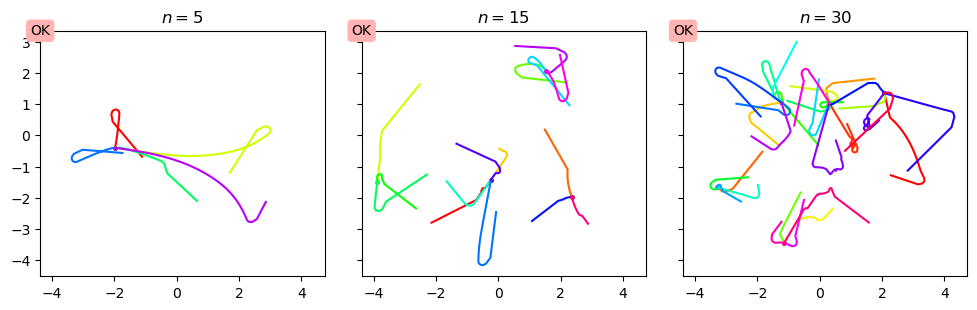

In [14]:
%%manim Swarm

np.random.seed(655321)

pol_pos = position_policy_1
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.25, max_angle_diff=np.radians(30))
pol_neighs = neighs_policy_nearest_global

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.tight_layout()
p1 = [Particle(init_pos=pos(3), init_vel=vel(1.5), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(5)]
p2 = [Particle(init_pos=pos(3), init_vel=vel(1.5), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(15)]
p3 = [Particle(init_pos=pos(3), init_vel=vel(1.5), get_neighbors=pol_neighs, get_position=pol_pos, get_velocity=pol_vel) for i in range(30)]
res = run_simulation(p1)
plot(res, title=r"$n = 5$", ax=ax[0])
plot(run_simulation(p2), title=r"$n = 15$", ax=ax[1])
plot(run_simulation(p3), title=r"$n = 30$", ax=ax[2])

class Swarm(HumanSwarm):
    def setup(self):
        self.sim = res

Convergence will also not always be reached in the form of an equilibrium point, but it can also appear as a limit cycle. This happens for example when a group of particles tries to reach each other with an unfortunate combination of speed and maximum steering angle. In these cases, the simulator runs up to the maximum iterations number, and then simply stops.

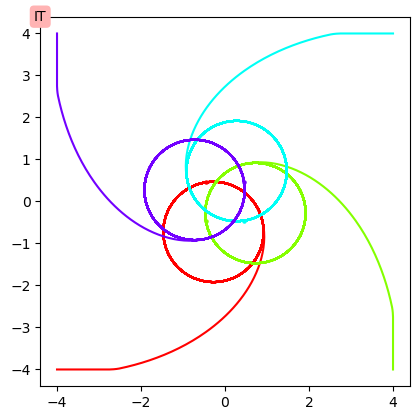

In [15]:
np.random.seed(998276)

x = 4.0  # initial coordinate
v = 1.0  # initial speed
a = 3    # maximum angle

pol_pos = position_policy_1
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=3.0, max_vel_diff=0.25, max_angle_diff=np.radians(a))

particles = [
    Particle(init_pos=np.array([-x,-x]), init_vel=np.array([ v,0.]), get_neighbors=[1, 1], get_position=pol_pos, get_velocity=pol_vel), 
    Particle(init_pos=np.array([ x,-x]), init_vel=np.array([ 0.,v]), get_neighbors=[2, 2], get_position=pol_pos, get_velocity=pol_vel), 
    Particle(init_pos=np.array([ x, x]), init_vel=np.array([-v,0.]), get_neighbors=[3, 3], get_position=pol_pos, get_velocity=pol_vel), 
    Particle(init_pos=np.array([-x, x]), init_vel=np.array([0.,-v]), get_neighbors=[0, 0], get_position=pol_pos, get_velocity=pol_vel)]
plot(run_simulation(particles))

### Policy 2

Now, we start to explore the second policy, still starting with a simple scenario. Convergence of this policy is strongly related to the order in which neighbors are found, since their relative position directly influences the output of the positioning policy. This behaviour never appeared with the first policy because each particle was simply aiming for a point bounded between the positions of its neighbors, while now the neighbors are "projecting" each particle onto one of the two semi-segments of the line passing through them, changing drastically the direction of the particle. Due to numerical issues, we will use a very discounted velocity, so to better represent a countinuous-time behaviour, which will be analyzed later.

To illustrate the behaviour explained above, we will distinguish two modes for the policy: normal (neighbors are used in their order) and flipped (neighbors are used in reverse). We place the particles around a circumpherence centered at the origin, and equip them with a specific list policy neighbors, so to create a cyclic chase. This means that every particle on the circumpherence will see as its neighbors the first two particles found by starting at the particle's position and following the circumpherence in a counter clockwise fashion. We set each initial velocity to zero and use the simple velocity policy. The positioning policy is then studied in its two modes: on the first row, we can see the normal case, while in the second row the flipped case.

We immediately see that the particles have a convergent behaviour in the first row (normal chase), while they are diverging in the second row (flipped chase). Let's analyze the second row first. As we can see, the flipped policy places the desired next position in such a way that the next velocity pushes the particles outside the initial spanned region. This clearly creates a expanding spiraling motion, resulting in a divergent behaviour. Switching to the first row now, we can see instead that due to the desired next position being "on the other side", each particle is drawn towards the center of the initial spanned region, resulting in a shrinking spiraling motion that ultimately converges. Finally, let's address the three-particles scenario, which results in a diverging behaviour regardless of the neighbor ordering. In general, these scenarios will always produce the same trajectories, just with different chirality. In fact, the symmetry of the equilateral triangle renders the order of neighbors totally ignorable in this case as long as the cyclic dependency is satisfied.

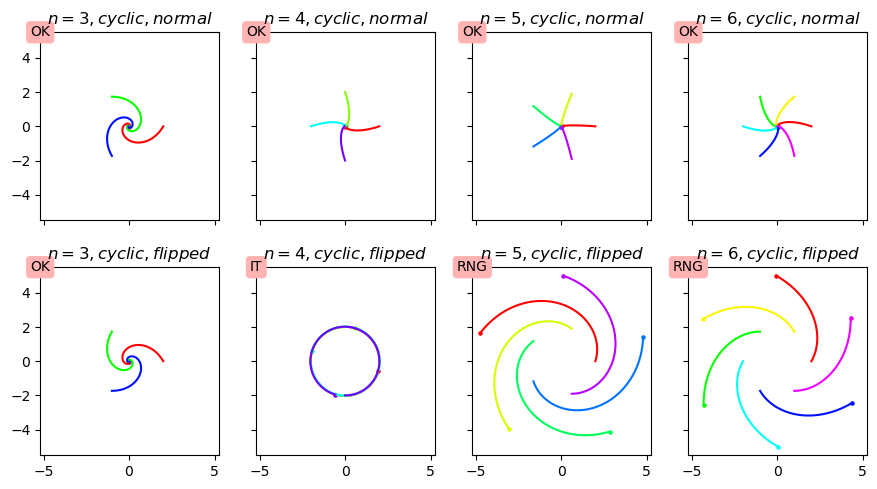

In [16]:
np.random.seed(621763)

n = 3  # initial number of particles
poss = lambda i, n : 2*np.array([np.cos(i/n*2*np.pi), np.sin(i/n*2*np.pi)])
pol_vel = lambda x, dx : velocity_policy_simple(x, dx, discount=0.001)

N = 3  # number of extra particles starting by n
fig, ax = plt.subplots(2, N+1, figsize=(9, 5), sharex=True, sharey=True)
fig.tight_layout()

pol_pos = lambda x, o : position_policy_2(x, o, flipped=False)
for i in range(N+1):
    particles = [Particle(init_pos=poss(j, n+i), get_neighbors=[(j+1)%(n+i), (j+2)%(n+i)], get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    plot(run_simulation(particles, term_radius=5), title=rf"$n = {n+i}, cyclic, normal$", ax=ax[0,i])

pol_pos = lambda x, o : position_policy_2(x, o, flipped=True)
for i in range(N+1):
    particles = [Particle(init_pos=poss(j, n+i), get_neighbors=[(j+1)%(n+i), (j+2)%(n+i)], get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    plot(run_simulation(particles, term_radius=5), title=rf"$n = {n+i}, cyclic, flipped$", ax=ax[1,i])

Getting more theoretical now, we said that the behaviour of the system is convergent in the first row and divergent in the second, with the exception of the three-particles scenario, which always converges. Starting with the second row, the system can be described as the following linear dynamical system
$$\dot{\xi}_i = (\xi_j + (\xi_j - \xi_k)) - \xi_i$$
where $\xi_j$ is the next particle counter-clockwise and $\xi_k$ the second next. Wlof we can describe the system with
$$
\begin{matrix}
\dot{\xi}_1 = -\xi_1 +2\xi_2 -\xi_3 \\
\dot{\xi}_2 = -\xi_1 -\xi_2 +2\xi_3 \\
\dot{\xi}_3 = 2\xi_1 -\xi_2 -\xi_3
\end{matrix}
\implies 
\begin{bmatrix} \dot{\xi}_1 \\ \dot{\xi}_2 \\ \dot{\xi}_3 \end{bmatrix} 
= \begin{bmatrix} -I_2 & 2I_2 & -I_2 \\\ -I_2 & -I_2 & 2I_2 \\\ 2I_2 & -I_2 & -I_2 \end{bmatrix} 
\begin{bmatrix} \xi_1 \\ \xi_2 \\ \xi_3 \end{bmatrix}
$$
while we can use the following matrices for the four- and five-particles systems:
$$
A_4 = \begin{bmatrix} -I_2 & 2I_2 & -I_2 & O_2 \\ O_2 & -I_2 & 2I_2 & -I_2 \\ -I_2 & O_2 & -I_2 & 2I_2 \\ 2I_2 & -I_2 & O_2 & -I_2 \end{bmatrix} 
\qquad
A_5 = \begin{bmatrix} -I_2 & 2I_2 & -I_2 & O_2 & O_2 \\ O_2 & -I_2 & 2I_2 & -I_2 & O_2 \\ O_2 & O_2 & -I_2 & 2I_2 & -I_2 \\ -I_2 & O_2 & O_2 & -I_2 & 2I_2 \\ 2I_2 & -I_2 & O_2 & O_2 & -I_2 \end{bmatrix} 
$$
with $O_2$ being the two-dimentional null matrix. Studying (for each axis) the eigenvalues of the system now

In [17]:
A3 = np.array([[-1,  2, -1], 
               [-1, -1,  2], 
               [ 2, -1, -1]])
A4 = np.array([[-1,  2, -1,  0], 
               [ 0, -1,  2, -1], 
               [-1,  0, -1,  2], 
               [ 2, -1,  0, -1]])
A5 = np.array([[-1,  2, -1,  0,  0], 
               [ 0, -1,  2, -1,  0], 
               [ 0,  0, -1,  2, -1], 
               [-1,  0,  0, -1,  2], 
               [ 2, -1,  0,  0, -1]])
with np.printoptions(precision=2, suppress=True):
    print(np.sort(np.linalg.eigvals(A3)))
    print(np.sort(np.linalg.eigvals(A4)))
    print(np.sort(np.linalg.eigvals(A5)))

[-1.5-2.6j -1.5+2.6j -0. +0.j ]
[-4.+0.j  0.-2.j  0.+2.j  0.+0.j]
[-2.93-2.13j -2.93+2.13j  0.  +0.j    0.43-1.31j  0.43+1.31j]


we can finally understand why we see a convergent behaviour in the first column, a limit cycle in the second, and a divergent behaviour in the last two. In fact, looking at the eigenvalues, we can see how the three-particles scenario has two asymptotically stable modes and one zero (meaning convergence), the four-particles scenario has only one asymptotically stable mode and three zeros (meaning undamped oscillatory motion in the shape of a circle), while the five-particles has two unstable modes (meaning divergence).

Moving on to the first row, the system can be described similarly as the following linear dynamical system
$$\dot{\xi}_i = (\xi_k + (\xi_k - \xi_j)) - \xi_i$$
where $\xi_j$ is the next particle counter-clockwise and $\xi_k$ the second next (note the difference in the order of $j$ and $k$). Using the same system description used above, wlof we can describe the three-, four-, and five-particles systems with the matrices
$$
A_3 = \begin{bmatrix} -I_2 & -I_2 & 2I_2 \\ 2I_2 & -I_2 & -I_2 \\ -I_2 & 2I_2 & -I_2 \end{bmatrix} 
\qquad
A_4 = \begin{bmatrix} -I_2 & -I_2 & 2I_2 & O_2 \\ O_2 & -I_2 & -I_2 & 2I_2 \\ 2I_2 & O_2 & -I_2 & -I_2 \\ -I_2 & 2I_2 & O_2 & -I_2 \end{bmatrix} 
\qquad
A_5 = \begin{bmatrix} -I_2 & -I_2 & 2I_2 & O_2 & O_2 \\ O_2 & -I_2 & -I_2 & 2I_2 & O_2 \\ O_2 & O_2 & -I_2 & -I_2 & 2I_2 \\ 2I_2 & O_2 & O_2 & -I_2 & -I_2 \\ -I_2 & 2I_2 & O_2 & O_2 & -I_2 \end{bmatrix} 
$$
Studying (for each axis) the eigenvalues of the system now

In [18]:
A3 = np.array([[-1, -1,  2], 
               [ 2, -1, -1], 
               [-1,  2, -1]])
A4 = np.array([[-1, -1,  2,  0], 
               [ 0, -1, -1,  2], 
               [ 2,  0, -1, -1], 
               [-1,  2,  0, -1]])
A5 = np.array([[-1, -1,  2,  0,  0],
               [ 0, -1, -1,  2,  0],
               [ 0,  0, -1, -1,  2],
               [ 2,  0,  0, -1, -1],
               [-1,  2,  0,  0, -1]])
with np.printoptions(precision=2, suppress=True):
    print(np.sort(np.linalg.eigvals(A3)))
    print(np.sort(np.linalg.eigvals(A4)))
    print(np.sort(np.linalg.eigvals(A5)))

[-1.5-2.6j -1.5+2.6j  0. +0.j ]
[-3.-1.j -3.+1.j  0.+0.j  2.+0.j]
[-2.93-0.22j -2.93+0.22j  0.  +0.j    0.43-2.49j  0.43+2.49j]


we see something unexpected. In fact, the three-particles system is still convergent (it has the exact same eigenvalues since this $A_3$ matrix is just the trasnposition of the previous $A_3$ matrix), but the other two systems are divergent, which is different from what we see in the plots! This is due to the "lucky" choice of initial positions. In fact, using $\xi_i = [\cos(i/n\ 2\pi), \sin(i/n\ 2\pi)]$ with $i = 0, ..., n-1$ and $n$ the number of particles (we have shifted the indices for convenience and ignored the actual radius of the initial circumpherence) creates a unique orbit that spirals towards the center. 

To prove this, next we propose again the examples from the first row above, but slitly moved away from the perfect circumpherence conditions. See how now the system shows its true (divergent) behaviour when the scenario has more than 3 particles.

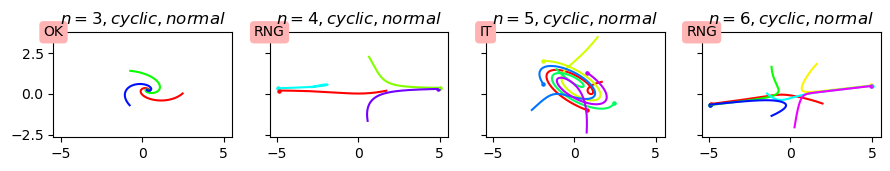

In [19]:
np.random.seed(621763)

n = 3  # initial number of particles
poss = lambda i, n : 2*np.array([np.cos(i/n*2*np.pi), np.sin(i/n*2*np.pi)]) + np.random.normal(0.1, 0.5, (2,))
pol_vel = lambda x, dx : velocity_policy_simple(x, dx, discount=0.001)
pol_neighs = lambda x, y, j, p: neighs_policy_list(x, y, [p[(j+1)%len(p)], p[(j+2)%len(p)]])

N = 3  # number of extra particles starting by n
fig, ax = plt.subplots(1, N+1, figsize=(9, 5), sharex=True, sharey=True)
fig.tight_layout()

pol_pos = lambda x, o : position_policy_2(x, o, flipped=False)
for i in range(N+1):
    particles = [Particle(init_pos=poss(j, n+i), get_neighbors=[(j+1)%(n+i), (j+2)%(n+i)], get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    plot(run_simulation(particles, term_radius=5), title=rf"$n = {n+i}, cyclic, normal$", ax=ax[i])

We now focus on the three-particles scenario when the nearest neighbors policy and the constrained velocity policy are used. We force a linear initial disposition (actually, quasi-linear, for visualization purposes, but nothing changes nonetheless) to show how position and neighbor order alter the behaviour of the system. In the first row we can see normal mode, which uses the nearest neighbor as A and the second nearest neighbor as B while trying to place B between A and itself. Convergence is reached in none of the scenarios, but locality is always satisfied, meaning that the particles always appear in clusters orbiting around a certain point (or moving towards a direction, not seen in these examples). In the second row the flipped mode is shown, with clear signs of divergence. This is due to the fact that now the nearest neighbor is B and the second nearest neighbor is A, meaning that the particle will try to move away from B, make A and B move towards the particle and resulting in a comet-like behaviour. To counter-act this behaviour, we can equip a specific particle with a null velocity policy, as shown in the third row. Also, we can try to set a state space constraint, like in the last column of the third row, in which a circular state space with radius 2 has been involved. However, due to the smoothness of the circle, the particles will start "cometing" around the state space; a non-smooth state space (eg. box state space, not shown below) solves this problem. 

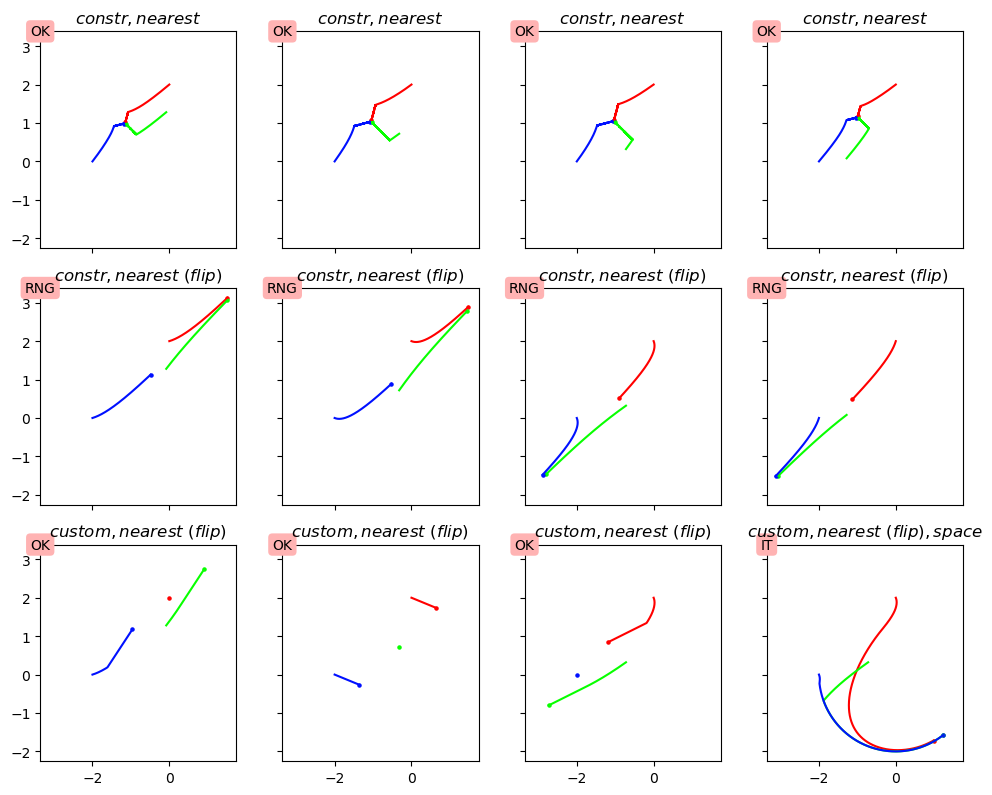

In [20]:
np.random.seed(621763)

poss = lambda a : a**2 * np.array([-2., 0.]) + (1-a)**2 * np.array([0., 2.])
pol_pos = lambda f : (lambda x, xd, f=f : position_policy_2(x, xd, flipped=f))
# pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=0.01, max_vel_diff=0.01, max_angle_diff=np.radians(45))
pol_vel = lambda x, dx : velocity_policy_simple(x, dx, discount=0.001)
pol_neighs = neighs_policy_nearest_global

N = 4
fig, ax = plt.subplots(3, N, figsize=(10, 8), sharex=True, sharey=True)
fig.tight_layout()

# n = 3, constr velocity, nearest neighbors
for i in range(N):
    particles = [
        Particle(init_pos=poss(0.), get_neighbors=pol_neighs, get_position=pol_pos(False), get_velocity=pol_vel),
        Particle(init_pos=poss((i+1)/(N+1)), get_neighbors=pol_neighs, get_position=pol_pos(False), get_velocity=pol_vel),
        Particle(init_pos=poss(1.), get_neighbors=pol_neighs, get_position=pol_pos(False), get_velocity=pol_vel)]
    plot(run_simulation(particles, term_radius=3), title=rf"$constr, nearest$", ax=ax[0,i])
# n = 3, constr velocity, nearest neighbors flipped
for i in range(N):
    particles = [
        Particle(init_pos=poss(0.), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel),
        Particle(init_pos=poss((i+1)/(N+1)), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel),
        Particle(init_pos=poss(1.), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel)]
    plot(run_simulation(particles, term_radius=3), title=rf"$constr, nearest\ (flip)$", ax=ax[1,i])
# n = 3, custom constr velocity, nearest neighbors flipped
pol_vel_still = lambda c : ((lambda x, xd : np.zeros((2,))) if c else pol_vel)
for i in range(N-1):
    particles = [
        Particle(init_pos=poss(0.), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel_still(i==0)),
        Particle(init_pos=poss((i+1)/(N+1)), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel_still(i==1)),
        Particle(init_pos=poss(1.), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel_still(i==2))]
    plot(run_simulation(particles, term_radius=3), title=rf"$custom, nearest\ (flip)$", ax=ax[2,i])
# n = 3, constr velocity, nearest neighbors flipped, state space
pol_space = lambda x : state_space_circle(x, radius=2)
particles = [
    Particle(init_pos=poss(0.), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel, state_space=pol_space),
    Particle(init_pos=poss(.6), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel, state_space=pol_space),
    Particle(init_pos=poss(1.), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel, state_space=pol_space)]
plot(run_simulation(particles, term_radius=4, max_iter=10000), title=rf"$custom, nearest\ (flip), space$", ax=ax[2,3])

Let us now relax the constraints on the initial position by randomly placing the particles in the space. Again, we see very different behaviour based on initial position (same in both rows), initial speed, maximum steering, but particularly on flipping direction. The first row, showning clustering behaviour, depicts normal mode, while the second row depicts flipped mode. Note that now, since the particles are also more than 3, we can see multiple comets. Also note how the three-particle system in the first row shows a cluster "moving towards a direction" as stated above.

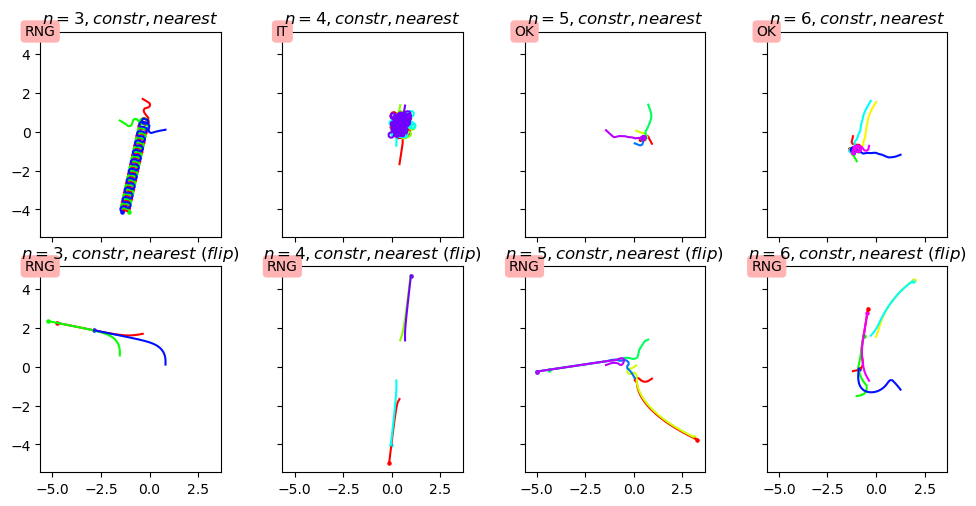

In [21]:
np.random.seed(621763)

n = 3  # initial number of particles
pol_pos = lambda f : (lambda x, xd, f=f : position_policy_2(x, xd, flipped=f))
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=5.0, max_vel_diff=0.45, max_angle_diff=np.radians(45))
pol_neighs = neighs_policy_nearest_global

N = 3  # number of extra particles starting by n
fig, ax = plt.subplots(2, N+1, figsize=(10, 5), sharex=True, sharey=True)
fig.tight_layout()

# n = {3,4,5}, constr velocity, nearest neighbors
for i in range(N+1):
    particles = [Particle(init_pos=pos(2), get_neighbors=pol_neighs, get_position=pol_pos(False), get_velocity=pol_vel) for j in range(n+i)]
    plot(run_simulation(particles, term_radius=5), title=rf"$n = {3+i}, constr, nearest$", ax=ax[0,i])

# n = {3,4,5}, constr velocity, nearest neighbors flipped
np.random.seed(621763)
for i in range(N+1):
    particles = [Particle(init_pos=pos(2), get_neighbors=pol_neighs, get_position=pol_pos(True), get_velocity=pol_vel) for j in range(n+i)]
    plot(run_simulation(particles, term_radius=5), title=rf"$n = {3+i}, constr, nearest\ (flip)$", ax=ax[1,i])

### Mixing policies

We now proceed to show some more advanced examples. With the provided functions, we might also reproduce the "word creation" scenario performed during the real-life experiment. By fixing for each particle the right neighbors, meaning that particles in the middle of the word use `position_policy_1` while particles at the beginning and end use `position_policy_2`, we can obtain a simulation that aligns all the particles in a straight line. The space between the particles can be set by modifying the default parameter in the policy functions. It must be noted that since the external particles are always placing themselves after the internal ones and these are placed between the external ones, the system always converges to a straight line, for a reasonable velocity policy.

In [22]:
%%manim Swarm

np.random.seed(228352)

pol_pos_1 = position_policy_1
pol_pos_2 = position_policy_2
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.45, max_angle_diff=np.radians(30))

particles = [
    Particle(init_pos=pos(4.5), init_vel=vel(0.1), get_neighbors=[2, 1], get_position=pol_pos_2, get_velocity=pol_vel), 
    Particle(init_pos=pos(4.5), init_vel=vel(0.1), get_neighbors=[0, 2], get_position=pol_pos_1, get_velocity=pol_vel), 
    Particle(init_pos=pos(4.5), init_vel=vel(0.1), get_neighbors=[1, 3], get_position=pol_pos_1, get_velocity=pol_vel), 
    Particle(init_pos=pos(4.5), init_vel=vel(0.1), get_neighbors=[2, 4], get_position=pol_pos_1, get_velocity=pol_vel), 
    Particle(init_pos=pos(4.5), init_vel=vel(0.1), get_neighbors=[3, 5], get_position=pol_pos_1, get_velocity=pol_vel), 
    Particle(init_pos=pos(4.5), init_vel=vel(0.1), get_neighbors=[3, 4], get_position=pol_pos_2, get_velocity=pol_vel)]
res = run_simulation(particles)
# plot(res)

class Swarm(HumanSwarm):
    def setup(self):
        self.sim = res

Manim Community v0.18.1

We can also produce shape-creation examples like the one below, in which the particles are instructed to create a square-like shape. This is achieved by forcing the corner particles to have the center in the middle while forcing the edge particles to be placed between the corners. To place th center, we introduce a new position policy that places the particle in the average of four other particles (ie the edge particles). Unfortunately, the shape is not a perfect square because we have no way of enforcing right angles. Try creating a positioning policy that does that! 

In [23]:
%%manim Swarm

np.random.seed(228242)

pol_pos_1 = position_policy_1
pol_pos_2 = position_policy_2
pol_pos_avg = lambda x, o : np.mean([p.pos for p in o])
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.45, max_angle_diff=np.radians(30))

particles = [
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[4, 8], get_position=pol_pos_2, get_velocity=pol_vel), 
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[0, 2], get_position=pol_pos_1, get_velocity=pol_vel),
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[6, 8], get_position=pol_pos_2, get_velocity=pol_vel), 
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[2, 4], get_position=pol_pos_1, get_velocity=pol_vel),
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[0, 8], get_position=pol_pos_2, get_velocity=pol_vel), 
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[4, 6], get_position=pol_pos_1, get_velocity=pol_vel),
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[2, 8], get_position=pol_pos_2, get_velocity=pol_vel), 
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[6, 0], get_position=pol_pos_1, get_velocity=pol_vel), 
    Particle(init_pos=pos(5), init_vel=vel(0.1), get_neighbors=[1, 3, 5, 7], get_position=pol_pos_avg, get_velocity=pol_vel)]
res = run_simulation(particles)
# plot(res)

class Swarm(HumanSwarm):
    def setup(self):
        self.sim = res

Manim Community v0.18.1

Finally, let's introduce some chaos. In particular, we allow the position and state space policies to be randomly chosen, while using a slow constrained velocity policy and a cone-shaped nearest neighbor policy, which chooses neighbors in front of the particle. In the simulation, we will see cones indicating the field of view of each particle if it is moving.

In [24]:
%%manim Swarm

np.random.seed(300524)

n = 10
pol_pos = lambda : np.random.choice([position_policy_1, position_policy_2])
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=2.5, max_vel_diff=0.9, max_angle_diff=np.radians(30))
perception_radius = 3.5
perception_angle = 2/3*np.pi
pol_neighs = lambda x, y : neighs_policy_nearest_cone(x, y, radius=perception_radius, angle=perception_angle)
pol_space_box = lambda x : state_space_box(x, size=(-3, +3, -3, +3))  # bottom, top, left, right
pol_space_circle = lambda x : state_space_circle(x, radius=3)
pol_space = lambda : np.random.choice([pol_space_box, pol_space_circle])

particles = [
    Particle(init_pos=pos(3), init_vel=vel(0.1), get_neighbors=pol_neighs, get_position=pol_pos(), get_velocity=pol_vel, state_space=pol_space()) 
    for _ in range(n)]
res = run_simulation(particles)
#plot(res)

class Swarm(HumanSwarm):
    def setup(self):
        self.sim, self.pr, self.pa = res, perception_radius, perception_angle

Manim Community v0.18.1